# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [2]:
df = pd.read_csv('data_full.csv')

In [3]:
data_num = df
target_tag = 'TotalGHGEmissions'
target = data_num[target_tag]
data_num = data_num.drop(labels = [target_tag,'SiteEnergyUse(kBtu)', 'ENERGYSTARScore'], axis = 1)

In [4]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Columns: 574 entries, 0 to ThirdLargestPropertyUseTypeGFA
dtypes: float64(574)
memory usage: 7.2 MB


## Modèle linéaire

In [5]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [6]:
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest = train_test_split(data_num, target, test_size = 0.2)

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)

#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 7}
GridCV results : 
r2 = -0.152 (+/- 1.173) for {'n_neighbors': 2}
r2 = 0.057 (+/- 0.453) for {'n_neighbors': 3}
r2 = 0.133 (+/- 0.317) for {'n_neighbors': 4}
r2 = 0.150 (+/- 0.208) for {'n_neighbors': 5}
r2 = 0.167 (+/- 0.180) for {'n_neighbors': 6}
r2 = 0.168 (+/- 0.147) for {'n_neighbors': 7}
r2 = 0.164 (+/- 0.112) for {'n_neighbors': 8}
r2 = 0.166 (+/- 0.097) for {'n_neighbors': 9}
r2 = 0.161 (+/- 0.096) for {'n_neighbors': 10}
r2 = 0.157 (+/- 0.102) for {'n_neighbors': 11}
r2 = 0.150 (+/- 0.087) for {'n_neighbors': 12}
r2 = 0.143 (+/- 0.082) for {'n_neighbors': 13}
r2 = 0.134 (+/- 0.077) for {'n_neighbors': 14}
r2 = 0.125 (+/- 0.070) for {'n_neighbors': 15}


In [7]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [8]:
def true_pred_plot(y_train,pred_train, y_test, pred_test):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    line_reg_train = line_reg.fit(np.array(pred_train).reshape(-1,1),y_train)
    r2_train = line_reg_train.score(np.array(pred_train).reshape(-1,1),y_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), ytrain.max()], linestyle = 'dashed')
    ax[0].text(0.7,0.7,'R2 : {:.3f} RMSE : {: .2f}.e6'.format(r2_train,rmse_train/1000000), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(-10,y_train.max())
    ax[0].set_ylim(-10,pred_train.max())
    ax[0].set_title('On train values')

    line_reg_test  = line_reg.fit(np.array(pred_test).reshape(-1,1),y_test)
    r2_test =  line_reg_test.score(np.array(pred_test).reshape(-1,1),y_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    ax[1].text(0.7,0.7,'R2 : {:.3f} RMSE : {: .2f}.e6'.format(r2_test, rmse_test/1000000), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(-10,y_test.max())
    ax[1].set_ylim(-10,pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.clf()

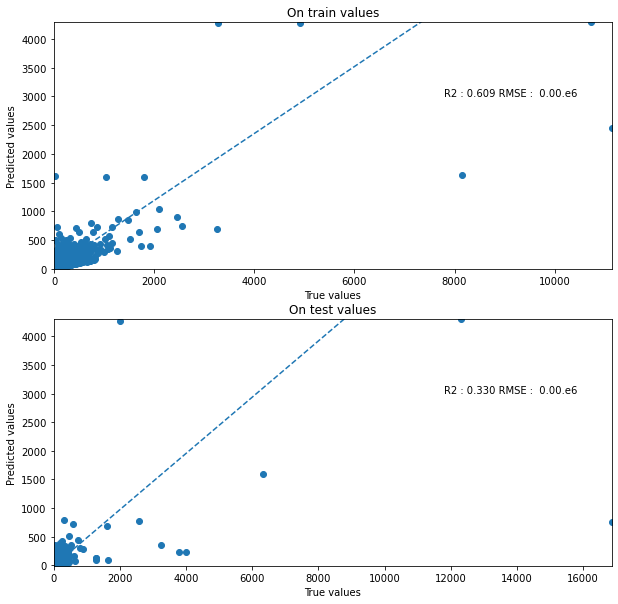

<Figure size 432x288 with 0 Axes>

In [9]:
model = KNeighborsRegressor(n_neighbors=7).fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

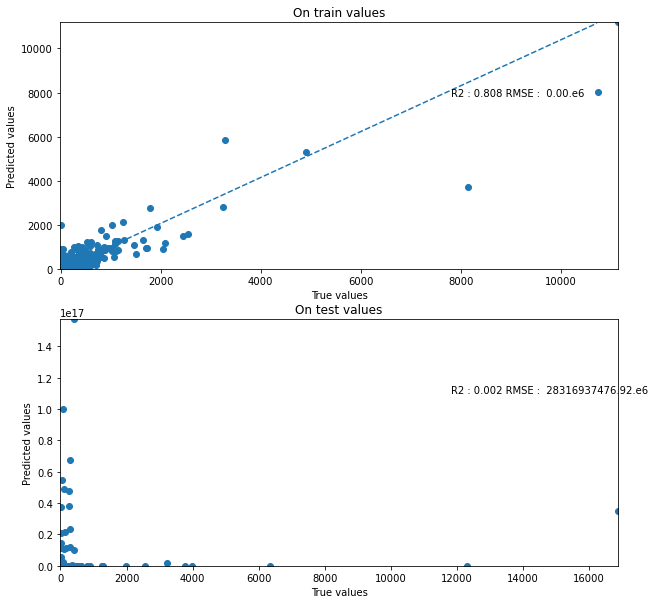

<Figure size 432x288 with 0 Axes>

In [10]:
line_reg_m = linear_model.LinearRegression()

line_reg_m.fit(xtrain,ytrain)


true_pred_plot(ytrain, line_reg_m.predict(xtrain), ytest, line_reg_m.predict(xtest))

In [11]:
print(ytest.max()/1000000, line_reg_m.predict(xtest).max()/1000000)

0.01687098 157517227318.06866


In [12]:
x = input('Do you want to launch ? [y/n]')
if x == 'y':

    #let's try with a svr
    C_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'rbf', 'sigmoid', 'poly']
    degrees = [2,3,4]
    gamma_range  = np.logspace(-2, 1, 10)
    #gamma_range = np.logspace(-2, 1, 10)
    #'gamma' : gamma_range
    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

    score = 'neg_mean_squared_error'

    svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

    svr_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(svr_cv.best_params_))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END ................degree=2, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ................degree=2, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ................degree=2, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................degree=2, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ...................degree=2, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ...................degree=2, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ...............degree=2, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...............degree=2, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...............degree=2, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ..................degree=2, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ..................degree=2, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ..................degree=2, gamma=0.0

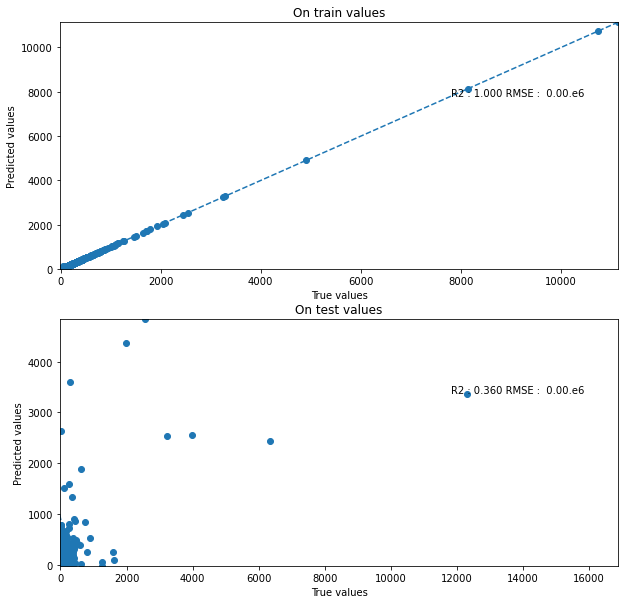

<Figure size 432x288 with 0 Axes>

In [13]:
svr = svm.SVR(kernel="poly", C=1.0, gamma = 0.2, degree = 2)
svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, svr.predict(xtrain), ytest, svr.predict(xtest))

In [14]:
from sklearn import kernel_ridge
#let's try with a ridge regression

x = input('Do you want to launch ? [y/n]')
if x == 'y':
    alpha_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'poly', 'sigmoid', 'rbf']
    degrees = [3,4,5]
    gamma_range  = np.logspace(-2, 1, 10)


    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}
    
    score = 'neg_mean_absolute_percentage_error'

    kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

    kernel_ridge_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_mo

Best params on training set : {'alpha': 100.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}


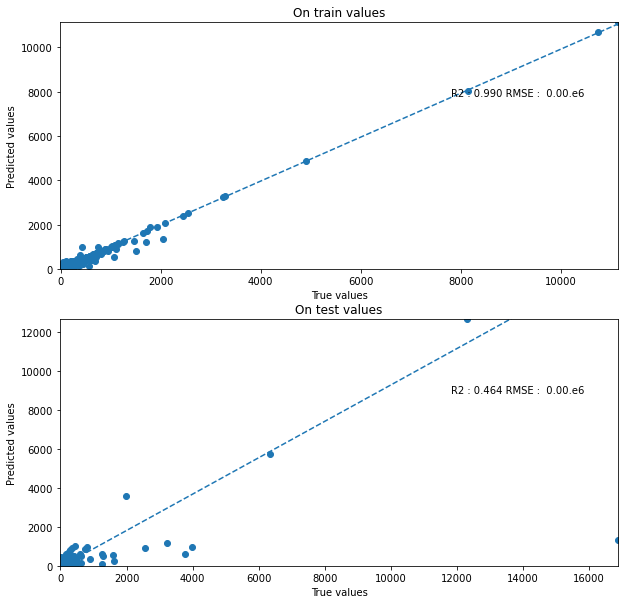

<Figure size 432x288 with 0 Axes>

In [15]:
model = kernel_ridge.KernelRidge(alpha = 100.0, kernel = 'rbf', degree = 3, gamma = 0.1)
model = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

## Neural network

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
#test with a single perceptron
model = keras.Sequential()
model.add(keras.Input(shape = xtrain.shape[1]))
model.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 575       
                                                                 
Total params: 575
Trainable params: 575
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(xtrain, ytrain, epochs = 50, batch_size = 4, verbose = 1)

Epoch 1/50
330/330 [==============================] - 1s 867us/step - loss: 99.3375 - root_mean_squared_error: 584.6260
Epoch 2/50
330/330 [==============================] - 0s 858us/step - loss: 97.0239 - root_mean_squared_error: 584.9751
Epoch 3/50
330/330 [==============================] - 0s 866us/step - loss: 94.8191 - root_mean_squared_error: 585.2488
Epoch 4/50
330/330 [==============================] - 0s 859us/step - loss: 93.1031 - root_mean_squared_error: 585.4086
Epoch 5/50
330/330 [==============================] - 0s 896us/step - loss: 91.5435 - root_mean_squared_error: 585.6579
Epoch 6/50
330/330 [==============================] - 0s 906us/step - loss: 90.4310 - root_mean_squared_error: 585.7808
Epoch 7/50
330/330 [==============================] - 0s 912us/step - loss: 89.5456 - root_mean_squared_error: 585.9727
Epoch 8/50
330/330 [==============================] - 0s 916us/step - loss: 88.8684 - root_mean_squared_error: 586.1447
Epoch 9/50
330/330 [====================

In [23]:
#now with a multi layer network

model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(383, activation="relu", name="layer2"),
        layers.Dense(287, activation="relu", name="layer2b"),
        layers.Dense(82, activation="relu", name="layer3"),
        layers.Dense(20, activation="relu", name="layer4"),
        layers.Dense(4, activation = "relu", name = "layer5"),
        layers.Dense(1, activation = 'linear', name="layer6"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 574)               330050    
                                                                 
 layer2 (Dense)              (None, 383)               220225    
                                                                 
 layer2b (Dense)             (None, 287)               110208    
                                                                 
 layer3 (Dense)              (None, 82)                23616     
                                                                 
 layer4 (Dense)              (None, 20)                1660      
                                                                 
 layer5 (Dense)              (None, 4)                 84        
                                                                 
 layer6 (Dense)              (None, 1)                

In [20]:
574/1.5

382.6666666666667

In [21]:
model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 4, verbose = 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 574)               330050    
                                                                 
 layer2 (Dense)              (None, 287)               165025    
                                                                 
 layer3 (Dense)              (None, 1)                 288       
                                                                 
Total params: 495,363
Trainable params: 495,363
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
330/330 [==============================] - 2s 3ms/step - loss: 90.8210 - root_mean_squared_error: 581.8242
Epoch 2/50
330/330 [==============================] - 1s 3ms/step - loss: 80.5462 - root_mean_squared_error: 578.2011
Epoch 3/50
330/330 [==============================] - 1s 3ms/step - loss: 73

In [22]:
history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 4, verbose = 1)

Epoch 1/50
330/330 [==============================] - 1s 3ms/step - loss: 13.2361 - root_mean_squared_error: 63.6068
Epoch 2/50
330/330 [==============================] - 1s 3ms/step - loss: 11.3278 - root_mean_squared_error: 57.2827
Epoch 3/50
330/330 [==============================] - 1s 3ms/step - loss: 10.8021 - root_mean_squared_error: 60.4828
Epoch 4/50
330/330 [==============================] - 1s 3ms/step - loss: 10.6611 - root_mean_squared_error: 56.8537
Epoch 5/50
330/330 [==============================] - 1s 3ms/step - loss: 10.5382 - root_mean_squared_error: 53.0963
Epoch 6/50
330/330 [==============================] - 1s 3ms/step - loss: 10.3325 - root_mean_squared_error: 59.4096
Epoch 7/50
330/330 [==============================] - 1s 3ms/step - loss: 10.5902 - root_mean_squared_error: 62.6427
Epoch 8/50
330/330 [==============================] - 1s 3ms/step - loss: 10.6116 - root_mean_squared_error: 58.9350
Epoch 9/50
330/330 [==============================] - 1s 3ms/ste